 # MNIST

In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
#mnist = fetch_mldata('MNIST original') # does not work for some reason, lots of others have the same problem on stackoverflow

In [3]:
# Alternative method to load MNIST, if mldata.org is down
from scipy.io import loadmat
from six.moves import urllib
#mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
#response = urllib.request.urlopen(mnist_alternative_url)
#with open(mnist_path, "wb") as f:
#    content = response.read()
#    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
}

In [4]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [5]:
X, y = mnist["data"], mnist["target"]

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [9]:
some_digit = X[36000]

In [10]:
some_digit_image = some_digit.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

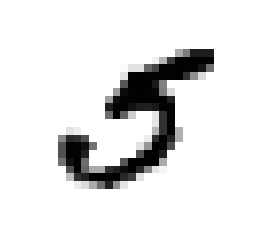

In [11]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")

In [12]:
y[36000]

5.0

In [13]:
#create test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
#shuffle the indices
import numpy as np
np.random.seed(42)

In [15]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [16]:
#only try to identify one digit: 5
y_train_5 = (y_train ==5 )

In [17]:
y_test_5 = (y_test == 5)

In [18]:
#use a Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/vlu747/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [19]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

# Perfomance Measures

## Measuring Accuracy Using Cross-Validation

In [20]:
#self implementing the cross_val_score() from sklearn, for this particular case
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42)

In [21]:
for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9502
0.96565
0.96495


In [22]:
#using sklearn
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring = "accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

In [23]:
#but check the classifier that only classifies everything as "not-5"
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [24]:
never_5_clf = Never5Classifier()

In [25]:
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

## Confusion Matrix

In [26]:
from sklearn.model_selection import cross_val_predict

In [27]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [30]:
from sklearn.metrics import precision_score, recall_score

In [31]:
precision_score(y_train_5,y_train_pred)

0.76871350203503808

In [32]:
recall_score(y_train_5, y_train_pred)

0.80132816823464303

In [33]:
from sklearn.metrics import f1_score #f1 score favours classifiers with similar precision and recall

In [34]:
f1_score(y_train_5,y_train_pred)

0.78468208092485547

In [35]:
y_scores = sgd_clf.decision_function([some_digit])

In [36]:
y_scores

array([ 161855.74572176])

In [37]:
threshold = 0

In [38]:
y_some_digit_pred = (y_scores>threshold)

In [39]:
y_some_digit_pred

array([ True], dtype=bool)

In [40]:
threshold = 200000

In [41]:
y_some_digit_pred = (y_scores > threshold)

In [42]:
y_some_digit_pred

array([False], dtype=bool)

In [43]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [44]:
y_scores.shape

(60000, 2)

In [45]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [46]:
from sklearn.metrics import precision_recall_curve

In [47]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [48]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--',label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])

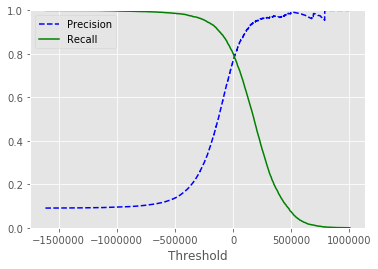

In [49]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

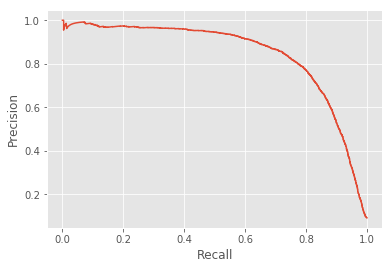

In [50]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

## ROC Curve

In [51]:
from sklearn.metrics import roc_curve

In [52]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [53]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

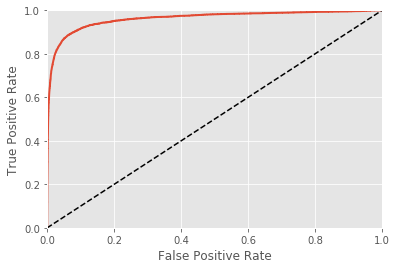

In [54]:
plot_roc_curve(fpr,tpr)

In [55]:
from sklearn.metrics import roc_auc_score

In [56]:
roc_auc_score(y_train_5, y_scores)

0.96244965559671547

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
forest_clf = RandomForestClassifier(random_state=42)

In [59]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = 'predict_proba')

In [60]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

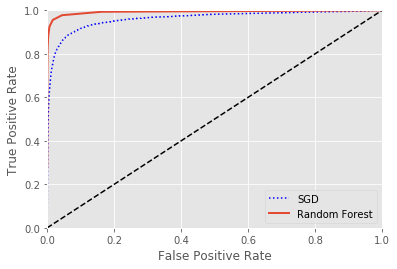

In [61]:
plt.plot(fpr,tpr,"b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [62]:
roc_auc_score(y_train_5,y_scores_forest)

0.99312433660038291

In [63]:
y_predict_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_predict_forest)

0.98529734474434938

In [64]:
recall_score(y_train_5,y_predict_forest)

0.82826046854823832

# Multiclass Classification

In [65]:
# One vs All classifier using SGDClassifier (Scholastic Gradient Descent)
sgd_clf.fit(X_train,y_train) #note this is y_train and not y_train_5
sgd_clf.predict([some_digit])

array([ 5.])

In [66]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [67]:
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [68]:
np.argmax(some_digit_scores)

5

In [69]:
#to actually see the classes
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [70]:
sgd_clf.classes_[5]

5.0

In [71]:
#force scikit-learn to use one vs one or one vs all, using OneVsOneClassifier or OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

/Users/vlu747/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 5.])

In [72]:
len(ovo_clf.estimators_)

45

In [73]:
#try with a random forest
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [74]:
forest_clf.predict([some_digit])

array([ 5.])

In [75]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [76]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy') #scores over all test folds

array([ 0.84063187,  0.84899245,  0.86652998])

In [78]:
#scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [79]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([ 0.91011798,  0.90874544,  0.906636  ])

# Error Analysis

In [80]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [82]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [83]:
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

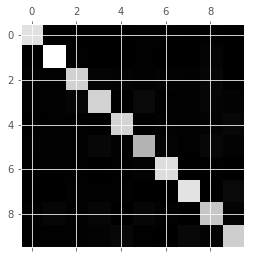

In [84]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

In [85]:
row_sums = conf_mx.sum(axis=1, keepdims = True)

In [86]:
norm_conf_mx = conf_mx / row_sums

In [87]:
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [88]:
norm_conf_mx

array([[  9.66570994e-01,   5.06500084e-04,   4.05200068e-03,
          1.51950025e-03,   1.68833361e-03,   8.27283471e-03,
          8.44166807e-03,   1.68833361e-03,   6.58450110e-03,
          6.75333446e-04],
       [  2.96647879e-04,   9.63067339e-01,   6.37792940e-03,
          3.70809849e-03,   1.03826758e-03,   5.93295758e-03,
          7.41619697e-04,   1.48323939e-03,   1.61673094e-02,
          1.18659152e-03],
       [  8.55991944e-03,   6.88150386e-03,   8.93084928e-01,
          1.74555220e-02,   1.49378986e-02,   4.36388050e-03,
          1.46022155e-02,   1.00704935e-02,   2.78616986e-02,
          2.18194025e-03],
       [  7.66595988e-03,   7.50285435e-03,   2.29978796e-02,
          8.71309737e-01,   1.63105529e-04,   3.76773773e-02,
          6.52422117e-03,   8.15527646e-03,   2.29978796e-02,
          1.50057087e-02],
       [  3.25231085e-03,   4.96405341e-03,   7.01814447e-03,
          1.71174255e-03,   9.18521054e-01,   1.54056830e-03,
          9.58575830e-03

In [89]:
np.fill_diagonal(norm_conf_mx, 0) #fill diagonal, keep only errors

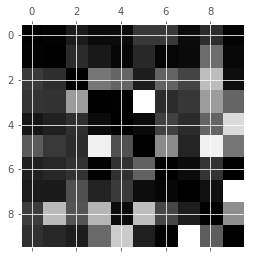

In [90]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [91]:
cl_a, cl_b = 3, 5

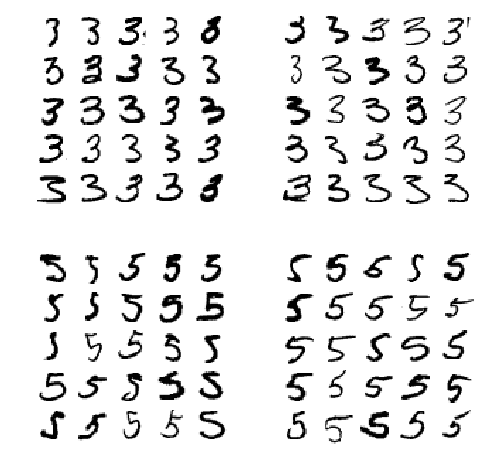

In [93]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)